# Sentiment Analysis with BERT

## Importing libraries

In [1]:
!pip install transformers

In [2]:
from pyspark.sql import SparkSession

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

/Users/zaftyguy/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


## Data Sampling

In [3]:
spark = SparkSession.builder.appName("Data Sampling for BERT model").getOrCreate()
reviewsDF = spark.read.json("data/yelp_academic_dataset_review.json")
reviewsDF.createOrReplaceTempView("review")

filtered_df = spark.sql("""
                        SELECT review_id, text, stars
                        FROM review
                        """)

filtered_df.show()

#randomly selecting data
sample_size = 10000
sampled_df = filtered_df.sample(withReplacement=False, fraction=sample_size/filtered_df.count(), seed=3)

pandasDF = sampled_df.toPandas()
pandasDF.head()

spark.stop()

25/05/16 20:59:20 WARN Utils: Your hostname, Justins-MacBook-Pro-5.local resolves to a loopback address: 127.0.0.1; using 100.64.11.184 instead (on interface en0)
25/05/16 20:59:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/16 20:59:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+--------------------+--------------------+-----+
|           review_id|                text|stars|
+--------------------+--------------------+-----+
|KU_O5udG6zpxOg-Vc...|If you decide to ...|  3.0|
|BiTunyQ73aT9WBnpR...|I've taken a lot ...|  5.0|
|saUsX_uimxRlCVr67...|Family diner. Had...|  3.0|
|AqPFMleE6RsU23_au...|Wow!  Yummy, diff...|  5.0|
|Sx8TMOWLNuJBWer-0...|Cute interior and...|  4.0|
|JrIxlS1TzJ-iCu79u...|I am a long term ...|  1.0|
|6AxgBCNX_PNTOxmbR...|Loved this tour! ...|  5.0|
|_ZeMknuYdlQcUqng_...|Amazingly amazing...|  5.0|
|ZKvDG2sBvHVdF5oBN...|This easter inste...|  3.0|
|pUycOfUwM8vqX7KjR...|Had a party of 6 ...|  3.0|
|rGQRf8UafX7OTlMNN...|My experience wit...|  5.0|
|l3Wk_mvAog6XANIuG...|Locals recommende...|  4.0|
|XW_LfMv0fV21l9c6x...|Love going here f...|  4.0|
|8JFGBuHMoiNDyfcxu...|Good food--loved ...|  4.0|
|UBp0zWyH60Hmw6Fsa...|The bun makes the...|  4.0|
|OAhBYw8IQ6wlfw1ow...|Great place for b...|  5.0|
|oyaMhzBSwfGgemSGu...|Tremendous servic...|  5.0|


## BERT Tokenization

In [21]:
MAX_LENGTH = 128
BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE = 2e-5

/var/folders/5m/n3lmdh1d5bl0t6d_1p3n_2wh0000gn/T/ipykernel_90178/935480887.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


<Axes: ylabel='Density'>

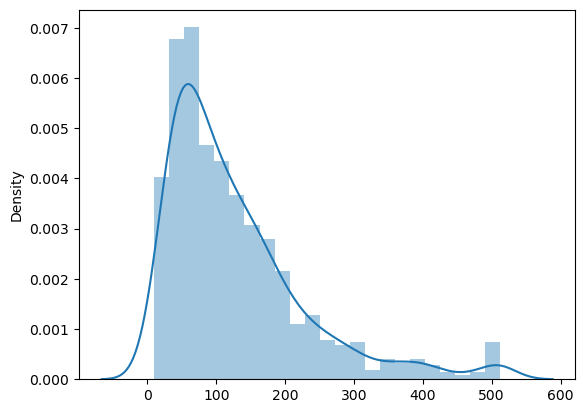

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
token_lens = []

for text in pandasDF['text'].sample(n=1000, random_state=3):
    tokens = tokenizer.encode(text, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
sns.distplot(token_lens)

Based on the distplot, we will pick a max_length of around 400 tokens.

In [6]:
texts = pandasDF['text'].tolist()
labels = pandasDF['stars'].tolist()

def tokenize_batch(texts, max_length=MAX_LENGTH):
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

X_train, X_temp, y_train, y_temp = train_test_split(
    texts, labels, test_size=0.3, random_state=3, stratify=labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=3, stratify=y_temp
)

train_encodings = tokenize_batch(X_train)
val_encodings = tokenize_batch(X_val)
test_encodings = tokenize_batch(X_test)

y_train = torch.tensor([label - 1 for label in y_train], dtype=torch.long)
y_val = torch.tensor([label - 1 for label in y_val], dtype=torch.long)
y_test = torch.tensor([label - 1 for label in y_test], dtype=torch.long)

train_dataset = TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    y_train
)

val_dataset = TensorDataset(
    val_encodings['input_ids'],
    val_encodings['attention_mask'],
    y_val
)

test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    y_test
)

## Creating Data Loader

In [7]:
train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=BATCH_SIZE
)

val_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=BATCH_SIZE
)

test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=BATCH_SIZE
)

## Training Model

In [22]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=5,
    output_attentions=False,
    output_hidden_states=False
)

# Updates model's weights
optimizer = AdamW(model.parameters(), lr= LEARNING_RATE, eps= 1e-8)
trainingSteps = len(train_dataloader) * EPOCHS

# Makes sure that learning rate doesn't overshoot by decreasing learning rate
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps= 0,
                                           num_training_steps= trainingSteps)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
model.to(device)
best_val_accuracy = 0

for i in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch_idx, batch in enumerate(train_dataloader):
        
        if batch_idx % 5 == 0:
            print(f"Batch {batch_idx}/{len(train_dataloader)}")
            
        inputId = batch[0].to(device)
        attenMask = batch[1].to(device)
        batchLabel = batch[2].to(device)

        model.zero_grad()

        outputs = model(input_ids= inputId, attention_mask= attenMask, labels= batchLabel)

        loss = outputs.loss
        total_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
    avg_train_loss = total_loss / len(train_dataloader)
    print(avg_train_loss)
    
    model.eval()
    total_val_loss = 0
    val_preds = []
    val_true = []
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(val_dataloader):
            if batch_idx % 5 == 0:
                print(f"Batch {batch_idx}/{len(val_dataloader)}")
            
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            total_val_loss += loss.item()
            
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            val_preds.extend(preds)
            val_true.extend(labels.cpu().numpy())
    
    avg_val_loss = total_val_loss / len(val_dataloader)
    val_accuracy = accuracy_score(val_true, val_preds)
    print(f"  Validation loss: {avg_val_loss:.4f}")
    print(f"  Validation accuracy: {val_accuracy:.4f}")
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), "best_bert_sentiment_model.pt")
        print("Model saved!")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/zaftyguy/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Batch 0/440
Batch 5/440
Batch 10/440
Batch 15/440
Batch 20/440
Batch 25/440
Batch 30/440
Batch 35/440
Batch 40/440
Batch 45/440
Batch 50/440
Batch 55/440
Batch 60/440
Batch 65/440
Batch 70/440
Batch 75/440
Batch 80/440
Batch 85/440
Batch 90/440
Batch 95/440
Batch 100/440
Batch 105/440
Batch 110/440
Batch 115/440
Batch 120/440
Batch 125/440
Batch 130/440
Batch 135/440
Batch 140/440
Batch 145/440
Batch 150/440
Batch 155/440
Batch 160/440
Batch 165/440
Batch 170/440
Batch 175/440
Batch 180/440
Batch 185/440
Batch 190/440
Batch 195/440
Batch 200/440
Batch 205/440
Batch 210/440
Batch 215/440
Batch 220/440
Batch 225/440
Batch 230/440
Batch 235/440
Batch 240/440
Batch 245/440
Batch 250/440
Batch 255/440
Batch 260/440
Batch 265/440
Batch 270/440
Batch 275/440
Batch 280/440
Batch 285/440
Batch 290/440
Batch 295/440
Batch 300/440
Batch 305/440
Batch 310/440
Batch 315/440
Batch 320/440
Batch 325/440
Batch 330/440
Batch 335/440
Batch 340/440
Batch 345/440
Batch 350/440
Batch 355/440
Batch 360/440


In [23]:
model.load_state_dict(torch.load("best_bert_sentiment_model.pt"))

model.eval()
test_preds = []
test_true = []

with torch.no_grad():
    for batch_idx, batch in enumerate(test_dataloader):
        if batch_idx % 5 == 0:
                print(f"Batch {batch_idx}/{len(test_dataloader)}")
                
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        test_preds.extend(preds)
        test_true.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_true, test_preds)
print(f"Test accuracy: {test_accuracy:.4f}")

Batch 0/95
Batch 5/95
Batch 10/95
Batch 15/95
Batch 20/95
Batch 25/95
Batch 30/95
Batch 35/95
Batch 40/95
Batch 45/95
Batch 50/95
Batch 55/95
Batch 60/95
Batch 65/95
Batch 70/95
Batch 75/95
Batch 80/95
Batch 85/95
Batch 90/95
Test accuracy: 0.6901


In [24]:
def get_predictions(texts):
    encodings = tokenize_batch(texts)
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
    logits = outputs.logits
    return torch.argmax(logits, dim=1).cpu().numpy() + 1

poke_reviews = pd.read_json("data/filtered_reviews_poke.json", lines=True)


batch_size = 32
predictions = []
total_batches = (len(poke_reviews['text']) + batch_size - 1) // batch_size

for i in range(0, len(poke_reviews['text']), batch_size):
    if i % (batch_size * 10) == 0:
        print(f"Processing batch {i//batch_size + 1}/{total_batches} ({i+1}-{min(i+batch_size, len(poke_reviews['text']))} of {len(poke_reviews['text'])} reviews)")
    
    batch_texts = poke_reviews['text'].iloc[i:i+batch_size].tolist()
    batch_preds = get_predictions(batch_texts)
    predictions.extend(batch_preds)


poke_reviews['predicted_sentiment'] = predictions
print(poke_reviews)

poke_reviews.to_csv('sentiment_analysis_full_results.csv', index=False)

Processing batch 1/543 (1-32 of 17358 reviews)
Processing batch 11/543 (321-352 of 17358 reviews)
Processing batch 21/543 (641-672 of 17358 reviews)
Processing batch 31/543 (961-992 of 17358 reviews)
Processing batch 41/543 (1281-1312 of 17358 reviews)
Processing batch 51/543 (1601-1632 of 17358 reviews)
Processing batch 61/543 (1921-1952 of 17358 reviews)
Processing batch 71/543 (2241-2272 of 17358 reviews)
Processing batch 81/543 (2561-2592 of 17358 reviews)
Processing batch 91/543 (2881-2912 of 17358 reviews)
Processing batch 101/543 (3201-3232 of 17358 reviews)
Processing batch 111/543 (3521-3552 of 17358 reviews)
Processing batch 121/543 (3841-3872 of 17358 reviews)
Processing batch 131/543 (4161-4192 of 17358 reviews)
Processing batch 141/543 (4481-4512 of 17358 reviews)
Processing batch 151/543 (4801-4832 of 17358 reviews)
Processing batch 161/543 (5121-5152 of 17358 reviews)
Processing batch 171/543 (5441-5472 of 17358 reviews)
Processing batch 181/543 (5761-5792 of 17358 revie

In [39]:
sns.histplot(poke_reviews['predicted_sentiment'], bins = 5)

KeyError: 'predicted_sentiment'

<Axes: xlabel='stars', ylabel='Count'>

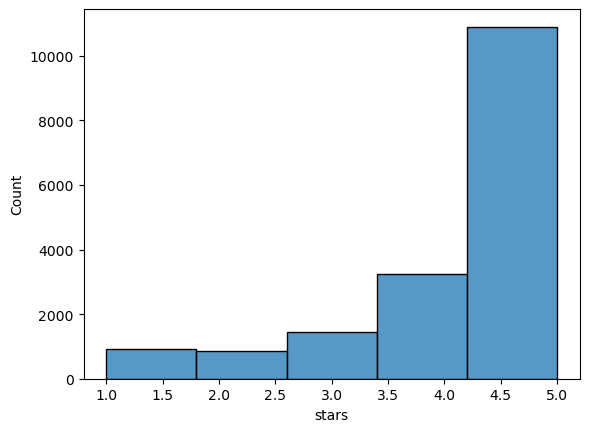

In [38]:
sns.histplot(poke_reviews['stars'], bins = 5)

## Using a Pre-Trained BERT Model from Hugging Face

In [34]:
!pip install torch transformers

#libraries
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification

BATCH_SIZE = 16

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [35]:
# reading poke reviews file
poke_reviews = pd.read_json("data/filtered_reviews_poke.json", lines=True)

# Model built for product reviews but should work for restaurant as well
model_name="nlptown/bert-base-multilingual-uncased-sentiment"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
model.to(device)


# Classifying ratings in batches
ratings = []

for i in range(0, len(poke_reviews['text']), BATCH_SIZE):
    batch = poke_reviews.iloc[i:i + BATCH_SIZE]
    batchtext = batch['text'].tolist()
    inputs = tokenizer(batchtext, padding=True, truncation=True, 
                            max_length=512, return_tensors="pt")
    
    for k, v in inputs.items():
        inputs[k] = v.to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    print(f"Processing batch {i} of {len(poke_reviews['text'])} reviews)")
    scores = torch.nn.functional.softmax(outputs.logits, dim=1)
    batch_ratings = torch.argmax(scores, dim=1).cpu().numpy() + 1
    ratings.extend(batch_ratings.tolist())
    
poke_reviews['predicted_sentiment2'] = ratings

Processing batch 0 of 17358 reviews)
Processing batch 16 of 17358 reviews)
Processing batch 32 of 17358 reviews)
Processing batch 48 of 17358 reviews)
Processing batch 64 of 17358 reviews)
Processing batch 80 of 17358 reviews)
Processing batch 96 of 17358 reviews)
Processing batch 112 of 17358 reviews)
Processing batch 128 of 17358 reviews)
Processing batch 144 of 17358 reviews)
Processing batch 160 of 17358 reviews)
Processing batch 176 of 17358 reviews)
Processing batch 192 of 17358 reviews)
Processing batch 208 of 17358 reviews)
Processing batch 224 of 17358 reviews)
Processing batch 240 of 17358 reviews)
Processing batch 256 of 17358 reviews)
Processing batch 272 of 17358 reviews)
Processing batch 288 of 17358 reviews)
Processing batch 304 of 17358 reviews)
Processing batch 320 of 17358 reviews)
Processing batch 336 of 17358 reviews)
Processing batch 352 of 17358 reviews)
Processing batch 368 of 17358 reviews)
Processing batch 384 of 17358 reviews)
Processing batch 400 of 17358 rev

Processing batch 3312 of 17358 reviews)
Processing batch 3328 of 17358 reviews)
Processing batch 3344 of 17358 reviews)
Processing batch 3360 of 17358 reviews)
Processing batch 3376 of 17358 reviews)
Processing batch 3392 of 17358 reviews)
Processing batch 3408 of 17358 reviews)
Processing batch 3424 of 17358 reviews)
Processing batch 3440 of 17358 reviews)
Processing batch 3456 of 17358 reviews)
Processing batch 3472 of 17358 reviews)
Processing batch 3488 of 17358 reviews)
Processing batch 3504 of 17358 reviews)
Processing batch 3520 of 17358 reviews)
Processing batch 3536 of 17358 reviews)
Processing batch 3552 of 17358 reviews)
Processing batch 3568 of 17358 reviews)
Processing batch 3584 of 17358 reviews)
Processing batch 3600 of 17358 reviews)
Processing batch 3616 of 17358 reviews)
Processing batch 3632 of 17358 reviews)
Processing batch 3648 of 17358 reviews)
Processing batch 3664 of 17358 reviews)
Processing batch 3680 of 17358 reviews)
Processing batch 3696 of 17358 reviews)


Processing batch 6592 of 17358 reviews)
Processing batch 6608 of 17358 reviews)
Processing batch 6624 of 17358 reviews)
Processing batch 6640 of 17358 reviews)
Processing batch 6656 of 17358 reviews)
Processing batch 6672 of 17358 reviews)
Processing batch 6688 of 17358 reviews)
Processing batch 6704 of 17358 reviews)
Processing batch 6720 of 17358 reviews)
Processing batch 6736 of 17358 reviews)
Processing batch 6752 of 17358 reviews)
Processing batch 6768 of 17358 reviews)
Processing batch 6784 of 17358 reviews)
Processing batch 6800 of 17358 reviews)
Processing batch 6816 of 17358 reviews)
Processing batch 6832 of 17358 reviews)
Processing batch 6848 of 17358 reviews)
Processing batch 6864 of 17358 reviews)
Processing batch 6880 of 17358 reviews)
Processing batch 6896 of 17358 reviews)
Processing batch 6912 of 17358 reviews)
Processing batch 6928 of 17358 reviews)
Processing batch 6944 of 17358 reviews)
Processing batch 6960 of 17358 reviews)
Processing batch 6976 of 17358 reviews)


Processing batch 9872 of 17358 reviews)
Processing batch 9888 of 17358 reviews)
Processing batch 9904 of 17358 reviews)
Processing batch 9920 of 17358 reviews)
Processing batch 9936 of 17358 reviews)
Processing batch 9952 of 17358 reviews)
Processing batch 9968 of 17358 reviews)
Processing batch 9984 of 17358 reviews)
Processing batch 10000 of 17358 reviews)
Processing batch 10016 of 17358 reviews)
Processing batch 10032 of 17358 reviews)
Processing batch 10048 of 17358 reviews)
Processing batch 10064 of 17358 reviews)
Processing batch 10080 of 17358 reviews)
Processing batch 10096 of 17358 reviews)
Processing batch 10112 of 17358 reviews)
Processing batch 10128 of 17358 reviews)
Processing batch 10144 of 17358 reviews)
Processing batch 10160 of 17358 reviews)
Processing batch 10176 of 17358 reviews)
Processing batch 10192 of 17358 reviews)
Processing batch 10208 of 17358 reviews)
Processing batch 10224 of 17358 reviews)
Processing batch 10240 of 17358 reviews)
Processing batch 10256 o

Processing batch 13088 of 17358 reviews)
Processing batch 13104 of 17358 reviews)
Processing batch 13120 of 17358 reviews)
Processing batch 13136 of 17358 reviews)
Processing batch 13152 of 17358 reviews)
Processing batch 13168 of 17358 reviews)
Processing batch 13184 of 17358 reviews)
Processing batch 13200 of 17358 reviews)
Processing batch 13216 of 17358 reviews)
Processing batch 13232 of 17358 reviews)
Processing batch 13248 of 17358 reviews)
Processing batch 13264 of 17358 reviews)
Processing batch 13280 of 17358 reviews)
Processing batch 13296 of 17358 reviews)
Processing batch 13312 of 17358 reviews)
Processing batch 13328 of 17358 reviews)
Processing batch 13344 of 17358 reviews)
Processing batch 13360 of 17358 reviews)
Processing batch 13376 of 17358 reviews)
Processing batch 13392 of 17358 reviews)
Processing batch 13408 of 17358 reviews)
Processing batch 13424 of 17358 reviews)
Processing batch 13440 of 17358 reviews)
Processing batch 13456 of 17358 reviews)
Processing batch

Processing batch 16288 of 17358 reviews)
Processing batch 16304 of 17358 reviews)
Processing batch 16320 of 17358 reviews)
Processing batch 16336 of 17358 reviews)
Processing batch 16352 of 17358 reviews)
Processing batch 16368 of 17358 reviews)
Processing batch 16384 of 17358 reviews)
Processing batch 16400 of 17358 reviews)
Processing batch 16416 of 17358 reviews)
Processing batch 16432 of 17358 reviews)
Processing batch 16448 of 17358 reviews)
Processing batch 16464 of 17358 reviews)
Processing batch 16480 of 17358 reviews)
Processing batch 16496 of 17358 reviews)
Processing batch 16512 of 17358 reviews)
Processing batch 16528 of 17358 reviews)
Processing batch 16544 of 17358 reviews)
Processing batch 16560 of 17358 reviews)
Processing batch 16576 of 17358 reviews)
Processing batch 16592 of 17358 reviews)
Processing batch 16608 of 17358 reviews)
Processing batch 16624 of 17358 reviews)
Processing batch 16640 of 17358 reviews)
Processing batch 16656 of 17358 reviews)
Processing batch

<Axes: xlabel='predicted_sentiment2', ylabel='Count'>

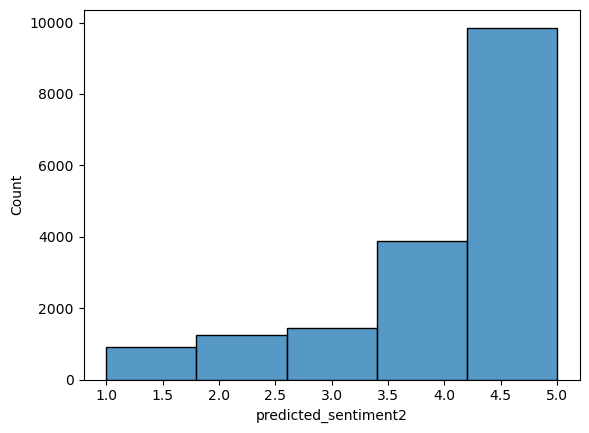

In [37]:
sns.histplot(poke_reviews['predicted_sentiment2'], bins = 5)

In [40]:
poke_reviews

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,predicted_sentiment2
0,cPepkJeRMtHapc_b2Oe_dw,1,2018-07-17 03:30:07,0,lUUhg8ltDsUZ9h0xnwY4Dg,4,I was really between 3 and 4 stars for this on...,1,RreNy--tOmXMl1en0wiBOg,3
1,hoYHhfn4w0mVjI60eHDHzA,0,2016-07-14 19:14:25,0,MDd6ndWo-NKn4sMy6UvgnQ,5,This is everything I want in take out food - f...,1,g2PdtlXNcAf6OFTp1rGLZQ,5
2,USekrAG0-4tJUs9V2gBBOQ,0,2016-10-14 01:12:42,1,lkdzFSsG-W1v7pP3nFMrGQ,5,Stopped in tonight for a light bite to eat. I ...,0,9a3N79voBcU4H9XQ8Ddb_Q,5
3,M1BkW7JZZBrCfT4_Sr4NEQ,0,2018-06-09 02:10:36,0,0t9rdI5VQyVqSv3HWsthlg,5,Delicious both the burritos and Vietnamese! Co...,0,GaA9W7Nhw3NAoSBHi7RQYA,5
4,M1BkW7JZZBrCfT4_Sr4NEQ,0,2017-07-08 20:49:07,0,FkIUt1u7hopE9YUIcNm4qw,5,I was fortunate to come across this lovely pla...,0,bnA5znt3FNwrnP9iLCKAbA,5
...,...,...,...,...,...,...,...,...,...,...
17353,OOv7OvZlExF2Z3Q569RtEw,0,2019-06-25 20:54:11,0,Upyjyvw1gk0GaFRPNOJFyQ,5,Stopped in w my son for a quick bite. Turned o...,2,qUpjAGzeL_2X0Yias-GFgw,5
17354,0dFeimiXpwXAC445r9xsVQ,0,2021-12-22 00:01:30,0,da1w9A71_W8A5RmswGaVWQ,5,Zushi always has very fresh sushi and amazing ...,0,m_kHhSYFjpKcWLi1aWD8oQ,3
17355,e747H7dlPXtZPo6VdSQelw,11,2018-11-12 10:32:02,2,5sDR1_lq_RfG4YnAOAq0oA,5,I love Nom Nom Bowl! When I came here for the ...,14,GR7-1pQrgIDcLXAtSpO3cQ,5
17356,0dFeimiXpwXAC445r9xsVQ,7,2018-09-22 01:08:57,5,MzRd9xWmmk-e88-VKis0oA,4,When I moved to Nashville the thing that I tho...,11,Kho08pWNfeGnRbZTnMKy3w,4


In [ ]:
poke_reviews.to_csv('poke_reviews_wSentiment.csv', index=False)